In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load a seasonal dataset
df1 = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('../Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

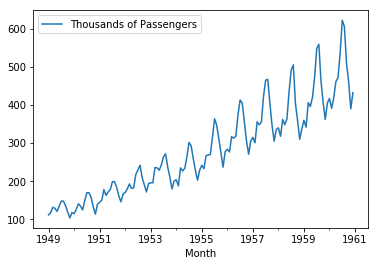

In [3]:
df1.plot()
# Non-stationary, since we have seasonality to it and a clear upward trend

- Lets use augmented Deqi fuller test to quantitatively configure that this is going to be a non-stationary data set. 
- And we need to do some import

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
# The way we run it :
adfuller(df1['Thousands of Passengers'])

# In this criterion/model, autolag='AIC' by default

(0.8153688792060423,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

- We got weird tuple of information
- Gotta use help(adfuller)
- Saw, whats being returned 
- Then we will format new test and out as shown below:

In [6]:
help(adfuller)

# Using help to see whats been returned which are adf pvalue, usedlag, nobs, critical, values, icbest, resstore


Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        data series
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}
    regression : {'c','ct','ctt','nc'}
        Constant and trend order to include in regression
    
        * 'c' : constant only (default)
        * 'ct' : constant and trend
        * 'ctt' : constant, and linear and quadratic trend
        * 'nc' : no constant, no trend
    autolag : {'AIC', 'BIC', 't-stat', None}
        * if None, then maxlag lags are used
        * if 'AIC' (default) or 'BIC', then the number of lags is chosen
          to minimize the corresponding information 

In [7]:
# Now we gonna format following:

dftest=adfuller(df1['Thousands of Passengers'])
dfout=pd.Series(dftest[0:4],index=['ADF Test Statistics','p-value','# Lags Used','# Observations'])

In [9]:
# Now we have a series and mention first 4 values after running adfuller
dfout

ADF Test Statistics      0.815369
p-value                  0.991880
# Lags Used             13.000000
# Observations         130.000000
dtype: float64

In [10]:
# Lets look at rest 3, which are Critical values for the test statistic at the 1 %, 5 %, and 10 %, done by formatting Dictionaries
for key,val in dftest[4].items():
    dfout[f'Critical value ({key})']=val

In [11]:
dfout

ADF Test Statistics       0.815369
p-value                   0.991880
# Lags Used              13.000000
# Observations          130.000000
Critical value (1%)      -3.481682
Critical value (5%)      -2.884042
Critical value (10%)     -2.578770
dtype: float64

- Most inportant thing above is the p-value as it tells if we should reject the null hypothesis or fail to reject it 

In [12]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
# lets run it on the time series
adf_test(df1['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


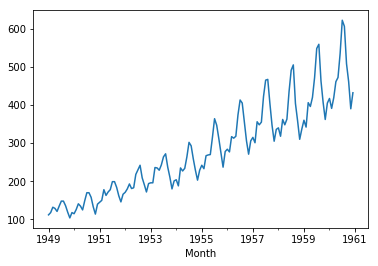

In [14]:
df1['Thousands of Passengers'].plot()

In [ ]:
- Lets look at df2, which is little harder to tell if its stationary or not just by looking at it 

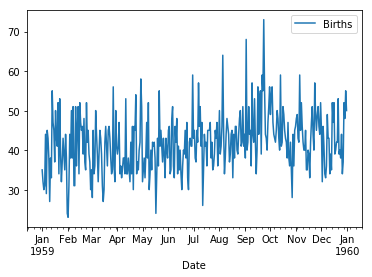

In [15]:
df2.plot()  

In [16]:
adf_test(df2['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


- Lets look at Granger Causality test

In [17]:
df3 = pd.read_csv('../Data/samples.csv',index_col=0,parse_dates=True)
df3.index.freq='MS'

In [19]:
# These are made up data

df3.head()


,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


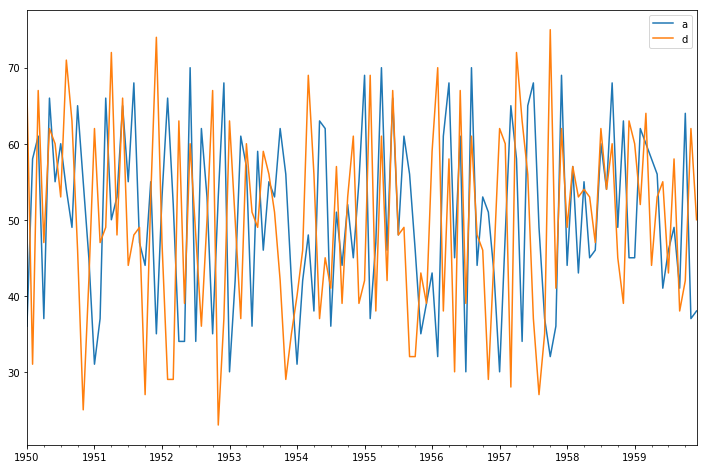

In [20]:
df3[['a', 'd']].plot(figsize=(12, 8)).autoscale(axis='x',tight=True)

- Hard to tell if any sort of causality between a and d 
- but for this data, if we shift one a little it is seen that there is causality

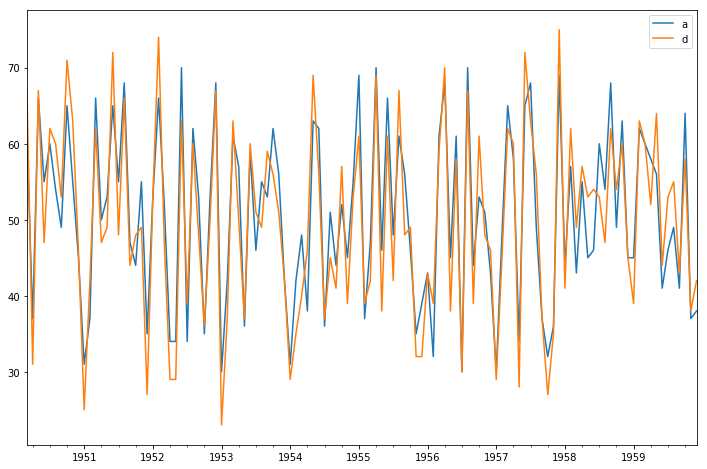

In [23]:
df3['a'].iloc[2:].plot(figsize=(12,8),legend=True).autoscale(axis='x',tight=True)
df3['d'].shift(2).plot(legend=True).autoscale(axis='x',tight=True)

- Now we can see that there is a good alignment here with a little bit of noise 
- This shows that 2 days after there is some change in d it looks like a is reflecting that 
- So there is some sort of evidence that d has a causality on 'a'.
- But the shift guess is not so easy, and thats where 'GRANGER CAUSALITY' comes into play.

In [24]:
from statsmodels.tsa.stattools import grangercausalitytests 

In [27]:
grangercausalitytests(df3[['a','d']],maxlag=3);

# Choosing maxlag here is a tradeoff between having more opportunities for causality to show up vs computational time.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


- We are looking at extremely low p values, which is at lag=2, so there is a causality between a and d
- Now we are gonna compare this to a dataset, where we know that there is no sort of causality between b and d

In [28]:
grangercausalitytests(df3[['b','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3


- Look at the p value above for any # lags, p is never less tha 0.05, means no causality

 if you're dealing with real data, maybe you're dealing with the price of jet fuel versus airline

stock data and you see strong indication of causality.

If jet fuel raises in price, maybe stock prices go down because tickets become more expensive or vice

versa, maybe to become more expensive if there's more profit, etc..

So those are the kind of things you really want to dive into.

And again, it's going to require domain knowledge to actually interpret those results.

In [29]:
# Evaluating Forecast Accuracy 
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['test','predictions'])

# np.random.randint(20,30,(50,2)), this means that from range 20-30, go ahead and give me 50rows/2columns,which is shape  

In [30]:
df.head()

,test,predictions
0,26,23
1,27,24
2,26,29
3,22,26
4,27,24


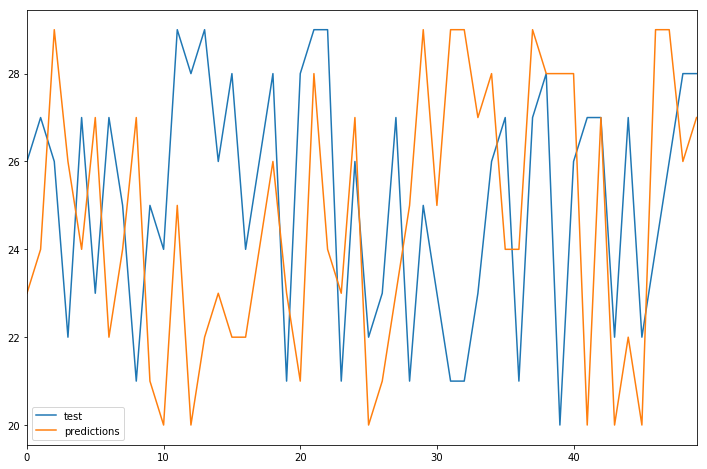

In [31]:
df.plot(figsize=(12,8)).autoscale(axis='x',tight=True)

- If we wanted to figure out, well, how off are we on our predictions,we can use methods MSE, RMSE
- One option is from sklearn
- One is statsmodel

In [33]:
from statsmodels.tools.eval_measures import mse,rmse,meanabs

In [34]:
mse(df['test'],df['predictions'])

17.02

In [35]:
rmse(df['test'],df['predictions'])

4.125530268947253

In [36]:
meanabs(df['test'],df['predictions'])

3.54

- So we can use whatever metric we want
- mostly people use rmse, because it both punishes those larger values and stays in the same units as original data 

- Lets expose seasonality with month and quater plots
- statsmodels has a useful function for us 

In [37]:
df = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)


In [38]:
df.index.freq='MS'

In [39]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


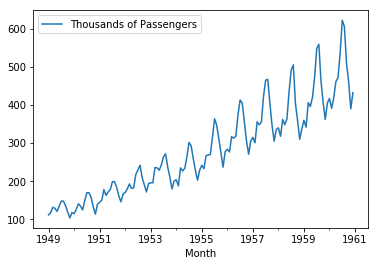

In [40]:
df.plot()

- here it is hard to tell where s the sasonality actually happening, we can easily just use following:

In [43]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

# This can seperate out all theese values per month or per quarter

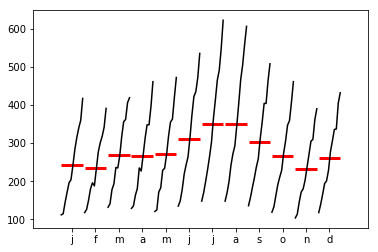

In [46]:
month_plot(df['Thousands of Passengers']);


- We can see above thatthere is an uptick during june and july and a little in december too 
- reason is vacation I believe

In [48]:
# Now if we want to format it by quarters 

dfq  = df['Thousands of Passengers'].resample(rule='Q').mean();

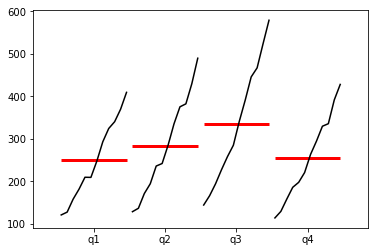

In [49]:
quarter_plot(dfq);